## Import Packages

In [1]:
import numpy as np
import pandas as pd
import pymatgen as pmg
import time

## Load training datasets from elastic_tensor.csv 

In [2]:
from matminer.datasets.dataframe_loader import load_elastic_tensor
from matminer.utils.conversions import str_to_composition

data = load_elastic_tensor() 

# Compute composition
data['composition'] = str_to_composition(data['formula'])

del_columns = ['formula', 'nsites', 'space_group', 
               'G_Reuss', 'G_Voigt', 'K_Reuss', 'K_Voigt',
               'compliance_tensor', 'elastic_tensor', 'elastic_tensor_original'
                ]

data = data.drop(del_columns, 1)

data.head(1)

,material_id,volume,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition
0,mp-10003,194.419802,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)"


## Build ML models

### Part 1: Compute Representation (Featurization) 

In [3]:
from matminer.featurizers import composition as cf
from matminer.featurizers import structure as struc
from matminer.featurizers.base import MultipleFeaturizer
from pymatgen import MPRester

key = 'ubX07DfzKy3mZAlw'

#### Holder Means of first 8 properties in Table 1 of De Jong et al. paper 
'group_number', 'atomic_mass', 'atomic_radius', 'row_number', 'boiling_temp', 'melting_temp', 'electronegativity', 'atomic_number'

$$\mu_p(x) = [\frac{(\Sigma^n_{i=1}w_ix_i^p)}{(\Sigma^n_{i=1}w_i)}]^\frac{1}{p}$$

In [4]:
def holder_means(comp, prop, p):
    '''Input:
            - comp = (Series) containing Pymatgen.Composition datatype
            - prop = (string) consists of one of the following input:
                     {'group number', 'atomic_mass', 'atomic_radius', 'row_number', 'boiling_temp', 'melting_temp', 'electronegativity', 'atomic_number'}
            - p = (int) power of Holder means between -4 and 4
        Output:
            - pandas.Series 
    '''
    n = comp.shape[0]
    output = np.zeros((n,))
    for i in range(n):
        total_weight = comp[i].weight
        if (p == 0):
            for j in comp[i].get_el_amt_dict():
                el = pmg.Element(j)
                wt = el.atomic_mass
                d = {'group_number': el.group, 'atomic_mass': el.atomic_mass, 
                     'atomic_radius': el.atomic_radius, 'row_number': el.row, 
                     'boiling_temp': el.boiling_point, 'melting_temp': el.melting_point, 
                     'electronegativity': el.X, 'atomic_number': el.Z}
                
                output[i] += wt*np.log(d[prop])
            output[i] = output[i]/total_weight
        else:
            for j in comp[i].get_el_amt_dict():
                el = pmg.Element(j)
                wt = el.atomic_mass
                d = {'group_number': el.group, 'atomic_mass': el.atomic_mass, 
                     'atomic_radius': el.atomic_radius, 'row_number': el.row, 
                     'boiling_temp': el.boiling_point, 'melting_temp': el.melting_point, 
                     'electronegativity': el.X, 'atomic_number': el.Z}
                output[i] += wt*d[prop]**p
            output[i] = (output[i]/total_weight)**(1.0/p)
    output = pd.Series(output)
    output.name = prop + '_%s' %p
    return output

In [5]:
p = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
prop = ['group_number', 'atomic_mass', 'atomic_radius', 'row_number', 'boiling_temp', 'melting_temp', 'electronegativity', 'atomic_number']

for i in p:
    for j in prop:
        series = holder_means(data['composition'], j, i)
        data[series.name] = series

data.head(1)

,material_id,volume,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition,group_number_-4,atomic_mass_-4,...,electronegativity_3,atomic_number_3,group_number_4,atomic_mass_4,atomic_radius_4,row_number_4,boiling_temp_4,melting_temp_4,electronegativity_4,atomic_number_4
0,mp-10003,194.419802,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)",7.335929,54.688924,...,1.281298,25.539391,7.591944,63.907321,1.090062,3.581085,3488.005226,1911.002204,1.389787,28.317874


#### Cohesive Energy

In [6]:
ft = cf.CohesiveEnergy(mapi_key=key)

data = ft.featurize_dataframe(data, col_id='composition', ignore_errors=True)

#### Formation energy per atom, Energy above hull, band gap, density

In [7]:
# Formation energy per atom, Energy above hull, band gap, density
property_list = ['formation_energy_per_atom', 'e_above_hull', 'band_gap', 'density']

mp = MPRester(api_key=key)

n = data.shape[0]
E_f, E_hull, E_g, rho = pd.Series(index=np.arange(n)), pd.Series(index=np.arange(n)), pd.Series(index=np.arange(n)), pd.Series(index=np.arange(n))

for i in range(n):
    ls = mp.get_data(data['material_id'][i])
    if (ls==[]):
        E_f[i], E_hull[i], E_g[i], rho[i] = 0.0, 0.0, 0.0, 0.0
    else:
        E_f[i] = ls[0]['formation_energy_per_atom']
        E_hull[i] = ls[0]['e_above_hull']
        E_g[i] = ls[0]['band_gap']
        rho[i] = ls[0]['density']

data['formation energy per atom'] = E_f
data['energy above hull'] = E_hull
data['band gap'] = E_g
data['density'] = rho

#### Volume (V) => log (V) per atom

In [8]:
data['log volume per atom'] = pd.Series(index=np.arange(n))
for i in range(len(data['volume'])):
    data['log volume per atom'][i] = np.log(data['volume'][i]/data['composition'][i].num_atoms)

#### Voronoi based site coordination, bond lengths and bond angles

In [9]:
ft = MultipleFeaturizer([
    struc.SiteStatsFingerprint.from_preset("CoordinationNumber_ward-prb-2017"),
    struc.StructuralHeterogeneity()
])

data = ft.featurize_dataframe(data, col_id='structure')

In [10]:
data.head(1)

,material_id,volume,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition,group_number_-4,atomic_mass_-4,...,avg_dev CN_VoronoiNN,mean absolute deviation in relative bond length,max relative bond length,min relative bond length,minimum neighbor distance variation,maximum neighbor distance variation,range neighbor distance variation,mean neighbor distance variation,avg_dev neighbor distance variation,mean absolute deviation in relative cell size
0,mp-10003,194.419802,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)",7.335929,54.688924,...,1.451453,0.048863,1.036647,0.911985,0.009816,0.080081,0.070264,0.058781,0.028399,0.105329


##### Data input

In [20]:
size = [10, 50, 100, 500, data.shape[0]]

from sklearn.utils import shuffle

variable_data = []
for i in range(len(size)):
    variable_data.append(shuffle(data)[:size[i]])

5

In [12]:
learned_feature = 'G_VRH'

In [30]:
from sklearn.preprocessing import Imputer

original_columns = ['material_id', 'volume', 'elastic_anisotropy', 'G_VRH', 
                    'K_VRH', 'poisson_ratio', 'structure', 'composition']

X = []
y = []
I = Imputer()
for i in range(len(variable_data)):
    x = variable_data[i].drop(original_columns, 1)
    X.append(I.fit_transform(x))
    y.append(np.log(variable_data[i][learned_feature]).as_matrix())

### Part 2: Choosing different ML models

ML model is built using scikit-learn package

<b>Split dataset into training and testing set...</b>

In [31]:
from sklearn.model_selection import KFold

num_splits = 5
kfold = KFold(num_splits, shuffle=False, random_state=0)

#### 1) Generalized Linear Models: Linear Regression, Lasso Regression and Ridge Regression

In [37]:
#Trying Cross Validation Prediction for linear models
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

m = len(size)

mae_lr, rmse_lr, r2_lr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))
mae_ridge, rmse_ridge, r2_ridge = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))


time_lr = np.zeros((m,))
time_ridge = np.zeros((m,))


print ("Linear Regression: ")
start_lr = time.monotonic()
for i in range(m):
    start_lr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        lr = linear_model.LinearRegression()
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        lr.fit(x_train, y_train)
        y_pred = lr.predict(x_test)

        mae_lr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_lr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_lr[i] += r2_score(y_test, y_pred) / num_splits

    finish_lr = time.monotonic()
    time_lr[i] = finish_lr - start_lr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_lr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_lr[i], rmse_lr[i], r2_lr[i]))
print ()


print ("Ridge Regression: ")
for i in range(m):
    start_ridge = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        ridge = linear_model.RidgeCV()
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        ridge.fit(x_train, y_train)
        y_pred = ridge.predict(x_test)

        mae_ridge[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_ridge[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_ridge[i] += r2_score(y_test, y_pred) / num_splits
    finish_ridge = time.monotonic()
    time_ridge[i] = finish_ridge - start_ridge
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_ridge[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_ridge[i], rmse_ridge[i], r2_ridge[i]))
print ()

Linear Regression: 
-- Size of dataset: 10
Time: 0.005813 seconds
MAE = 0.502930, RMSE = 3.174306, R-SQUARED = -11.371699
-- Size of dataset: 50
Time: 0.006713 seconds
MAE = 0.904638, RMSE = 6.241861, R-SQUARED = -3.370256
-- Size of dataset: 100
Time: 0.012256 seconds
MAE = 1.222421, RMSE = 9.209267, R-SQUARED = -5.820533
-- Size of dataset: 500
Time: 0.020380 seconds
MAE = 0.301047, RMSE = 2.197514, R-SQUARED = 0.622448
-- Size of dataset: 1181
Time: 0.038983 seconds
MAE = 0.261445, RMSE = 1.807864, R-SQUARED = 0.754232

Ridge Regression: 
-- Size of dataset: 10
Time: 0.006682 seconds
MAE = 0.503858, RMSE = 3.205577, R-SQUARED = -10.843776
-- Size of dataset: 50
Time: 0.006892 seconds
MAE = 0.619749, RMSE = 3.813704, R-SQUARED = -0.315331
-- Size of dataset: 100
Time: 0.012232 seconds
MAE = 0.391303, RMSE = 2.639771, R-SQUARED = 0.481391
-- Size of dataset: 500
Time: 0.031387 seconds
MAE = 0.279345, RMSE = 1.935637, R-SQUARED = 0.714639
-- Size of dataset: 1181
Time: 0.071810 seconds

#### 2) Support Vector Machines

In [ ]:
from sklearn import svm

In [ ]:
# %%time
# lin = svm.SVR(kernel='linear')
# lin = lin.fit(X, y)

# print ("linear kernel: ", lin.score(X, y))
# # No output because took too long or has error

In [ ]:
# %%time
# rbf = svm.SVR(kernel='rbf', gamma=0.1)
# rbf = rbf.fit(X, y)

# print ("rbf kernel: ", rbf.score(X, y))
# # No output because took too long or has error

#### 3) Ensemble method: RandomforestRegressor and ExtraTreesRegressor

In [39]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score


mae_rfr, rmse_rfr, r2_rfr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))
mae_efr, rmse_efr, r2_efr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

time_rfr = np.zeros((m,))
time_efr = np.zeros((m,))

n = 100

print ("Random Forest Regression: ")
for i in range(m):
    start_rfr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        rfr = RandomForestRegressor(n_estimators=n)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        rfr.fit(x_train, y_train)
        y_pred = rfr.predict(x_test)

        mae_rfr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_rfr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_rfr[i] += r2_score(y_test, y_pred) / num_splits
    finish_rfr = time.monotonic()
    time_rfr[i] = finish_rfr - start_rfr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_rfr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_rfr[i], rmse_rfr[i], r2_rfr[i]))
print ()

print ("Extra Trees Regression: ")
for i in range(m):
    start_efr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        efr.fit(x_train, y_train)
        y_pred = efr.predict(x_test)

        mae_efr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_efr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_efr[i] += r2_score(y_test, y_pred) / num_splits
    finish_efr = time.monotonic()
    time_efr[i] = finish_efr - start_efr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_efr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_efr[i], rmse_efr[i], r2_efr[i]))
print ()

Random Forest Regression: 
-- Size of dataset: 10
Time: 0.501721 seconds
MAE = 0.316840, RMSE = 1.713789, R-SQUARED = -6.006060
-- Size of dataset: 50
Time: 0.736303 seconds
MAE = 0.413235, RMSE = 2.533487, R-SQUARED = 0.467663
-- Size of dataset: 100
Time: 1.112026 seconds
MAE = 0.352317, RMSE = 2.515012, R-SQUARED = 0.507977
-- Size of dataset: 500
Time: 6.317094 seconds
MAE = 0.288100, RMSE = 1.973371, R-SQUARED = 0.708009
-- Size of dataset: 1181
Time: 18.123168 seconds
MAE = 0.259842, RMSE = 1.787621, R-SQUARED = 0.763887

Extra Trees Regression: 
-- Size of dataset: 10
Time: 0.442012 seconds
MAE = 0.216591, RMSE = 1.273896, R-SQUARED = 0.049860
-- Size of dataset: 50
Time: 0.631853 seconds
MAE = 0.410640, RMSE = 2.495174, R-SQUARED = 0.525267
-- Size of dataset: 100
Time: 0.919650 seconds
MAE = 0.328951, RMSE = 2.343690, R-SQUARED = 0.581885
-- Size of dataset: 500
Time: 3.244215 seconds
MAE = 0.278709, RMSE = 1.906190, R-SQUARED = 0.728790
-- Size of dataset: 1181
Time: 7.756928

#### 4) Ensemble method: GradientBoosting 

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae_gradient, rmse_gradient, r2_gradient = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))
time_gradient = np.zeros((m,))



print ("Gradient Boosting Regression: ")
for i in range(m):
    start_gradient = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        gradient = GradientBoostingRegressor(n_estimators=250, max_depth=3)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        gradient.fit(x_train, y_train)
        y_pred = gradient.predict(x_test)

        mae_gradient[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_gradient[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_gradient[i] += r2_score(y_test, y_pred) / num_splits
    finish_gradient = time.monotonic()
    time_gradient[i] = finish_gradient - start_gradient
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_gradient[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_gradient[i], rmse_gradient[i], r2_gradient[i]))
print ()

Gradient Boosting Regression: 
-- Size of dataset: 10
Time: 0.176761 seconds
MAE = 0.210809, RMSE = 1.256698, R-SQUARED = 0.002615
-- Size of dataset: 50
Time: 0.380994 seconds
MAE = 0.452964, RMSE = 2.775612, R-SQUARED = 0.437345
-- Size of dataset: 100
Time: 0.857590 seconds
MAE = 0.352041, RMSE = 2.438903, R-SQUARED = 0.543969
-- Size of dataset: 500
Time: 3.508292 seconds
MAE = 0.269244, RMSE = 1.882791, R-SQUARED = 0.733874
-- Size of dataset: 1181
Time: 7.656289 seconds
MAE = 0.248085, RMSE = 1.729659, R-SQUARED = 0.777940



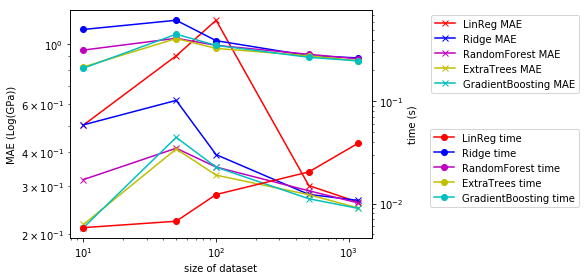

In [60]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_lr, color='r', marker='x', label='LinReg MAE')
ax1.loglog(size, mae_ridge, color='b', marker='x', label='Ridge MAE')
ax1.loglog(size, mae_rfr, color='m', marker='x', label='RandomForest MAE')
ax1.loglog(size, mae_efr, color='y', marker='x', label='ExtraTrees MAE')
ax1.loglog(size, mae_gradient, color='c', marker='x', label='GradientBoosting MAE')
ax1.legend(bbox_to_anchor=(1.7, 1))

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_lr, color='r', marker='o', label='LinReg time')
ax2.loglog(size, mae_ridge, color='b', marker='o', label='Ridge time')
ax2.loglog(size, mae_rfr, color='m', marker='o', label='RandomForest time')
ax2.loglog(size, mae_efr, color='y', marker='o', label='ExtraTrees time')
ax2.loglog(size, mae_gradient, color='c', marker='o', label='GradientBoosting time')
ax2.legend(bbox_to_anchor=(1.7, 0.5))

fig.tight_layout()
plt.show()